# Mastering Deep Learning with PyTorch: Step-by-Step Guide to Training Your First Model

This notebook follows a step-by-step process of training a neural network in PyTorch. The **objective is on learning the main processes and steps in constructing the modeling pipeline**. We will consider a computer vision classification problem, i.e. using a deep learning model to classify images in predefined categories.

When building a deep learning model there are five main things you should consider, namely:
- data availability and structure: construct a **dataloader** for each dataset
- model architecture: define a **model class**
- define a modeling pipeline with:
   - hyperparameters
   - loss function and the optimizers
   - model metrics

Consider the following figure below where the central point is the training and validation box to which we feed the information from our data, the model architecture, etc. to obtain the trained model with its results in the form of a model loss and metrics. This trained model, we can then use to further analyze the resutls on the test set and if all goes well, implement it in production.

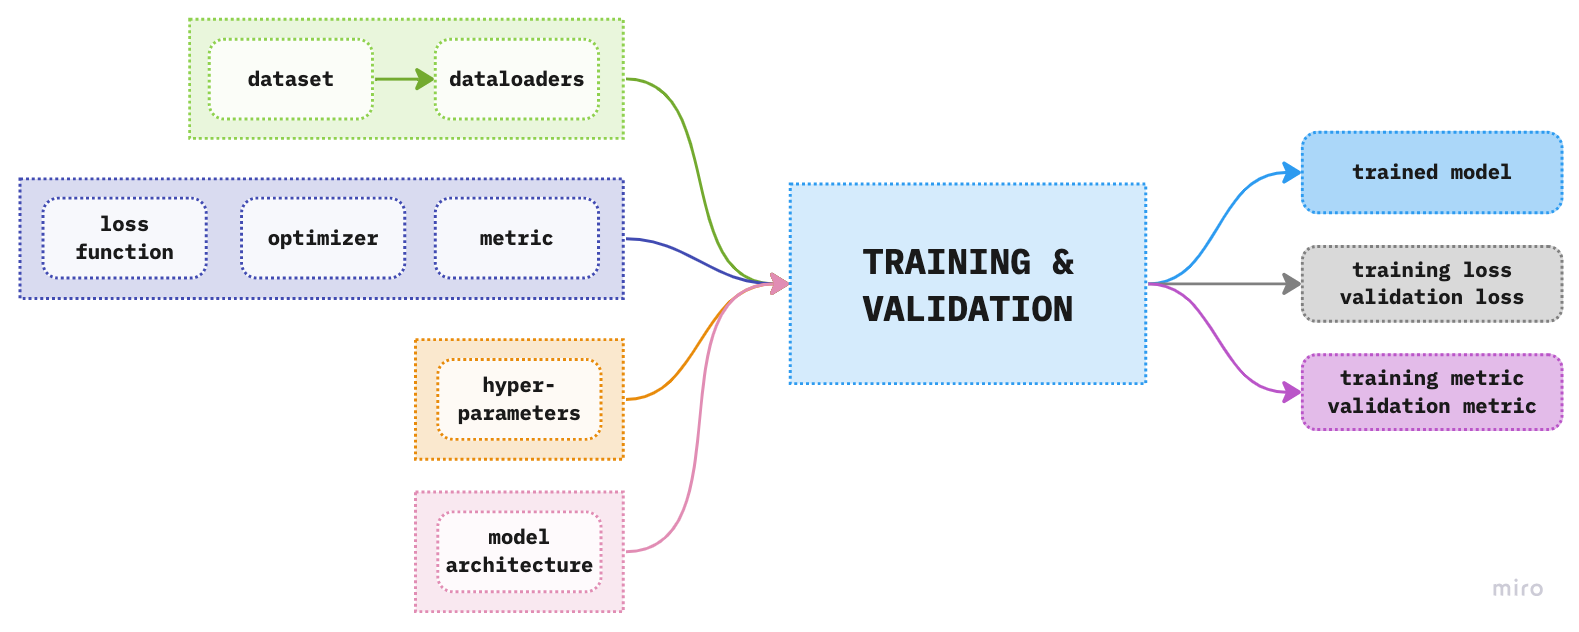
<cite>Figure 1. Overview of the components of deep learning modeling pipeline</cite><br><br>

Since this is our first step in training a neural network in PyTorch we will **focus on constructing the modeling pipeline**, i.e. the training and validation box in the above figure, which we can then use in other more complex problems. For this reason we will use the MNIST dataset provided in PyTorch. In the next notebook, we will explore further by using a more complex dataset to demonstrate the importance of constructing a custom dataset and related topics.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

from pathlib import Path
from termcolor import colored

import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import SubsetRandomSampler

After imports we define plot style and global variables. The purpose of global variables are such that they don't change during the course of the notebook, which is why we define them at the beginning of the notebook.

In [2]:
# Plotting style
plt.style.use('ggplot')

# Global variables
DATA_DIR = Path('/kaggle/working/data/')
MODELS_DIR = Path('/kaggle/working/models/')
MODELS_DIR.mkdir(parents=True, exist_ok=True)
SEED = 42

# Define custom colors for the labels
colors = ["#D9D2D8","#F2BBC9", "#BF849A", "#8C7A89", "#9AC7D9", 
          "#82C0D9", "#7DABB3", "#8F9FBF", "#737F99", "#566073"]
cmap = mcolors.ListedColormap(colors)

# Datasets and Dataloaders

To train anything we first need the data. For this project we will use the famous [MNIST dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) comprised of images of digits from 0 to 9 where our task is to predict the digit based on the image provided. The dataset is already provided in the `dataset` module of `torchvision` library. To view which datasets are available see the [link](https://pytorch.org/vision/stable/datasets.html).

To download the dataset we need to provide at least the following arguments: 
- `root`: where to save the downloaded files,
- `train`: should the train dataset be downloaded. If `False` then the test set is downloaded; and
- `download` whether to download the dataset. Note that if the data already exists locally in the provided `root` argument then the data will not be downloaded again. The dataset will be processed as PyTorch `DataSet`.

There are additional arguments such as `transform` which transforms the data. To illustrate each step separately we will use this option later on.

In [3]:
# Train set
data_train = datasets.MNIST(root=DATA_DIR, train=True, download=True)
# Test set
data_test = datasets.MNIST(root=DATA_DIR, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw



We can check how many images are in the training and test set using `len`. To obtain more information about the structure of each image we can use `.data.shape` which gives us the number of images and the size of each image, i.e. height and width.

In [4]:
print(f'Train data: {len(data_train)}')
print(f'Test data: {len(data_test)}')

print(f'\nTrain: {data_train.data.shape}')
print(f'Test: {data_test.data.shape}')

Train data: 60000
Test data: 10000

Train: torch.Size([60000, 28, 28])
Test: torch.Size([10000, 28, 28])


So in total there are 70000 images of handrwitten digits, where each is of size 28 by 28 pixels. Since the data is processed as a PyTorch dataset we know that each element of `data_train` is a tuple of inputs (images) and labels. To check the type of the input data we can use `type()` as shown below:

In [5]:
img, label = data_train[0]
print(type(img))

<class 'PIL.Image.Image'>


Since we haven't applied any transformations on the images, the data types of our input data is still a PIL image. Note that a computer can not take an image as an input data point of this form. We will have to transform it into numbers, i.e. tensors. Before we go and do this let's see how some of the images look like along with their corresponding target label. Below we define a simple plotting function which takes 9 random images from the training data and plots them using the blue gradient color. 

<div style="border: 0px solid #ccc; background-color: #BDD2D9; padding: 10px; margin: 14px 0; border-radius: 7px; font-size: 14px">
Note that if we had transformed the images into tensors we would have shape of `[1,28,28]` for one image. In order to use the below function we need to change line `plt.imshow(img, cmap='Blues')` to `plt.imshow(img.squeeze(), cmap='Blues')`. The method `squeeze()` removes any dimension of 1.
<div>

In [6]:
def show_sample(data):
    """Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html"""
    fig = plt.figure(figsize=(7,7))
    cols, rows = 3,3
    for i in range(1, cols*rows+1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        # Get image and the corresponding label
        img, label = data[sample_idx]
        fig.add_subplot(rows,cols,i)
        plt.imshow(img, cmap='Blues')
        plt.title(f'Label: {label}', size=10)
        plt.axis("off")
    plt.show()

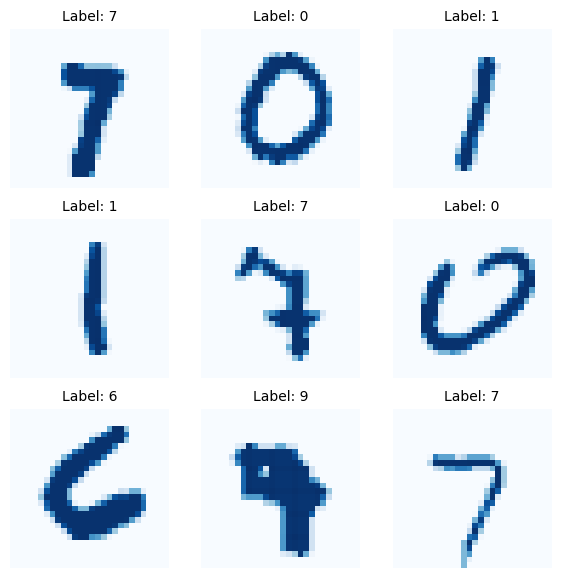

In [7]:
show_sample(data_train)

Each of the images is composed of pixels ranging from 0 to 255, where 0 represents white and 255 black. Let's transform the image to tensors and visualize it. We will apply `ToTensor()` which transforms the pixel values to the values in range of `(0,1)`.

In [8]:
# Extract the first image and its label from the dataset
imgT = ToTensor()(img)
print(f'Image dimension: {imgT.shape}')
print(f'Label: {label}')

Image dimension: torch.Size([1, 28, 28])
Label: 5


So the image size is 28 by 28 pixels and the first image should represent digit 5. Let's see the pixel data with gradient colors for better visualization. We will use pandas `style` to apply the gradient effect. Since our image is of rank 3 in order to convert it to a pandas dataframe we need to remove the first dimension. We will do this using the `numpy` `squeeze()` which removes axes of length 1. Below image gives us the normalized pixel representation of the first digit image in the training sample. The label for this image is 5.

In [9]:
dfimg = pd.DataFrame(imgT.squeeze().numpy())
dfimg.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues').format(precision=2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Let's apply the same transformation to both datasets:

In [10]:
# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

data_train.transform = transform
data_test.transform = transform

## Prepare dataset for training: Create dataloaders

Previously we have downloaded two datasets: training and testing. To be able to deduce whether our model is overfitting during training we need another dataset, namely, validation set. The validation set will show us how our model performs on out-of-sample data, i.e. data that have not been used in training.

We will generate the validation dataset by randomly sampling from the training dataset since it is much bigger than the given test set, naturally.

For this problem, we can assume that the images in the dataset are independent and don't have any underlying relationship structure, like time. If this is not the case we should think about the underlying structure when splitting the dataset (more on this in later notebooks). The main aspect we should worry about is the distribution of digits in all datasets. Ideally, we want the digits to be distributed in the same way in all datasets, so when creating the dataset for validation we should keep this in mind. 

For example, we may encounter two types of imbalance: **training imbalance** and **testing imbalance**. In training imbalance, the classes represented are not uniformly distributed, i.e. there is a significant perentage of one or several classes compared to the rest of the classes in the dataset. On the other hand, testing imbalance refers to the imbalance between training and testing dataset. For example, if we would have a training set with an extremly small number of say digits 3 but a large sample of digits 3 in the test set then the model has a very limited information scope to learn from, but it is expected to know 3s very well in out-of-sample settings. You can notice that in this case there is most probably evidence of both imbalance problems.

To begin, it is usefull to know how the labels are named. We can use `class_to_idx` to get the dictionary of labels in our dataset.

In [11]:
# Get mapping of target IDs
print(data_train.class_to_idx)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


To check the distributions of labels in our training and testing dataset visually we compute a bar plot of each:

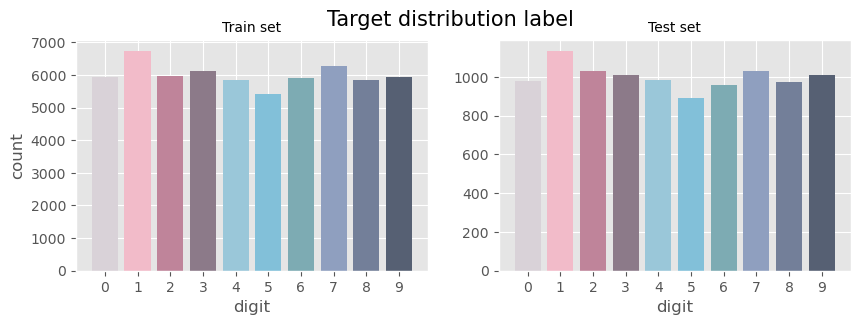

In [12]:
# Create dataframe for each dataset
df = pd.DataFrame(pd.Series(data_train.targets).value_counts().reset_index())
df.columns = ['digit', 'count']
df.sort_values('digit', inplace=True)
dft = pd.DataFrame(pd.Series(data_test.targets).value_counts().reset_index())
dft.columns = ['digit', 'count']
dft.sort_values('digit', inplace=True)

# Define plot structure
fig,_=plt.subplots(1,2, figsize=(10,3))
plt.suptitle('Target distribution label', size=15)

# Plot the train set
plt.subplot(1,2,1)
plt.bar('digit', 'count',data=df, color=cmap(df.digit))
plt.title('Train set', size=10)
plt.xlabel('digit')
plt.xticks(range(len(df.digit)), df.digit)
plt.ylabel('count')

# Plot the test set
plt.subplot(1,2,2)
plt.bar('digit', 'count',data=dft, color=cmap(dft.digit))
plt.title('Test set', size=10)
plt.xlabel('digit')
plt.xticks(range(len(dft.digit)), dft.digit)

plt.show()

We can see from above figures that the target distributions for both training and test sets are similar and all digits are represented relatively in a balanced structure, which means we can just split the training data randomly into training and validation sets. As noted previously if the sample is not balanced then when splitting the sample we should preserve the sample imblance.

We will use `SubsetRandomSampler` to select the data. The `SubsetRandomSampler` uses indices from the original dataset to randomly and without replacement select subsets of data. So, first we need to define which indices are for the training sample and which are to be used for the validation sample. Generally, if there is no underlying structure in the data, i.e. the samples are independent, it is good practice to shuffle the data before selecting the indices. This ensures that we will have samples from the complete set of data. Note that the function `SubsetRandomSampler` selects random indices from the given list, however, we need to first define from which list to select these samples from. 

We will construct the training set to be 70% of the indices of the original downloaded training dataset. The remaining 30% will be allocated to validation dataset. The steps are:

In [13]:
# Step 1 - Length of train dataset from which we are splitting the data
Nd = len(data_train); print(f'Dataset length: {Nd}')

# Step 2 - Create a shuffled list of training indices to ensure
# there are indices from the complete set in the final selection
Nd_idx = list(range(Nd))
np.random.shuffle(Nd_idx)
print(f'Shuffled indices {Nd_idx[:5]}')

# Step 3 - Define percentage of indices for the training sample
# to compute number of indices to be included in the training sample
train_pct = 0.7
Nt = int(np.floor(train_pct * Nd))
print(f'Number of indices to include in training set: {Nt}')

# Step 4 - Split the indices into training and validation
tr_idx, vl_idx = Nd_idx[:Nt], Nd_idx[Nt:]

# Pass the indices to the SubsetRandomSampler
tr_sampler = SubsetRandomSampler(tr_idx)
vl_sampler = SubsetRandomSampler(vl_idx)

print(f'\nTrain idx length: {len(tr_sampler)}')
print(list(tr_sampler)[:5])
print(f'\nValid idx length: {len(vl_sampler)}')
print(list(vl_sampler)[:5])

Dataset length: 60000
Shuffled indices [43388, 19889, 24362, 41574, 48805]
Number of indices to include in training set: 42000

Train idx length: 42000
[53649, 12533, 31829, 29996, 32349]

Valid idx length: 18000
[9178, 24647, 14896, 7682, 17078]


Now, that we have the samplers for training and validation, we can create iterable objects for each dataset which will contain all the information used in the training process with respect to the input data. These objects are called **dataloaders**.

In order to train the model using PyTorch there are two basic requirements in regards to the input data:
1. the dataset has to be in the form of a tuple with the structure (input, label) where each is a tensor
2. the input data should be stored in batches, i.e. the input data is iterable over batches.

Note that the initial data is already in form of tuples, as we saw previously. To create the iterable batches we will use a PyTorch object called `DataLoader` which takes a Python collection and converts it to an iterator based on batches. From the PyTorch documentation we have:

> Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset. [Ref](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoaderhttps://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

Since we have datasets and the corresponding samplers we can proceed to create dataloaders, but before actually constructing dataloaders let's check what we have got in training and validation datasets. We also need to check whether there are any partial batches, i.e. leftover samples when constructing mini-batches. Note that there is an option in `DataLoader` called `drop_last` to drop any such letfovers. In the function below we are computing, based on our defined `samplers`, how many batches we should expect from the datasets and whether there are letfover samples, i.e. incomplete batches.

In [14]:
# Define number of batches
no_batches = 64

In [15]:
def check_batches(sampler, batch_size):
    
    # Number of samples to expect in the final dataloader
    no_samples = len(sampler)
    
    # Number of batches to expect in the final dataloader
    no_batches = int(np.ceil(no_samples / batch_size))
    print(f'Number of batches total: {no_batches}')
    
    # Samples in the last batch (leftover samples)
    lb_samples = no_samples % batch_size
    
    if lb_samples != 0:
        no_batches -= 1
    
    print(f'Full batches: {no_batches}')
    if lb_samples != 0:
        print(f'Samples in partial batch: {lb_samples}')
    
    return no_batches, lb_samples

We can apply the above function on training and validation sample:

In [16]:
print('Training sample')
tr_batches, tr_lb_samples = check_batches(tr_sampler, no_batches)
print('\nValidation sample')
vl_batches, vl_lb_samples = check_batches(vl_sampler, no_batches)

Training sample
Number of batches total: 657
Full batches: 656
Samples in partial batch: 16

Validation sample
Number of batches total: 282
Full batches: 281
Samples in partial batch: 16


Now, let's finally create dataloaders. 

<div style="border: 0px solid #ccc; background-color: #DBBCC3; padding: 10px; margin: 14px 0; border-radius: 7px; font-size: 14px">
Note that we can not use `shuffle=True` when using `SubsetRandomSampler()` by construction.
<div>

In [17]:
# Training dataloader
dl_train = torch.utils.data.DataLoader(data_train, batch_size=no_batches, shuffle=False, sampler=tr_sampler)

# Validation dataloader
dl_valid = torch.utils.data.DataLoader(data_train, batch_size=no_batches, shuffle=False, sampler=vl_sampler)

# Test dataloader
dl_test = torch.utils.data.DataLoader(data_test, batch_size=no_batches, shuffle=True)

To check the size of the dataloader we can use `len()` which will give us the number of batches created for each dataset. The numbers for the batches from the dataloaders align with what we have calculated from the samplers. 

In [18]:
print(f'Training batches: {len(dl_train)}')
print(f'Validation batches: {len(dl_valid)}')
print(f'Test batches: {len(dl_test)}')

Training batches: 657
Validation batches: 282
Test batches: 157


<div style="border: 0px solid #ccc; background-color: #F0E8C5; padding: 10px; margin: 14px 0; border-radius: 7px; font-size: 14px">
Since we have constructed training and validation dataloaders from the original dataset using sampler, if we call `len(dl_train.dataset)` it will give us the number of samples of the original dataset, i.e. 60000, and not 42000 and 18000 respectively. We will see how this applies later on in the code when we will compute the average loss and metric for the epoch of training.
</div>

In [19]:
print(len(dl_train.dataset), len(dl_valid.dataset))

60000 60000


Finally let's check the shape of one batch:

In [20]:
for batch in dl_train:
    X, y = batch
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')
    break

X shape: torch.Size([64, 1, 28, 28])
y shape: torch.Size([64])


So, everything looks good, we have batches with the correct number of samples and the shapes of each sample is 28 by 28 with 1 channel since the images were given in gray scale and not in RGB (then we would have 3 channels instead of 1).

# Training Pipeline

Now that we have our dataloaders ready we can go to the next step and define the components of the training pipeline. From Figure 1. we can see that the main components of the training pipeline are: the loss function, optimizer, metric, hyperparameters and the model architecture. We can now extend that figure to include more details on the training and validation phase 

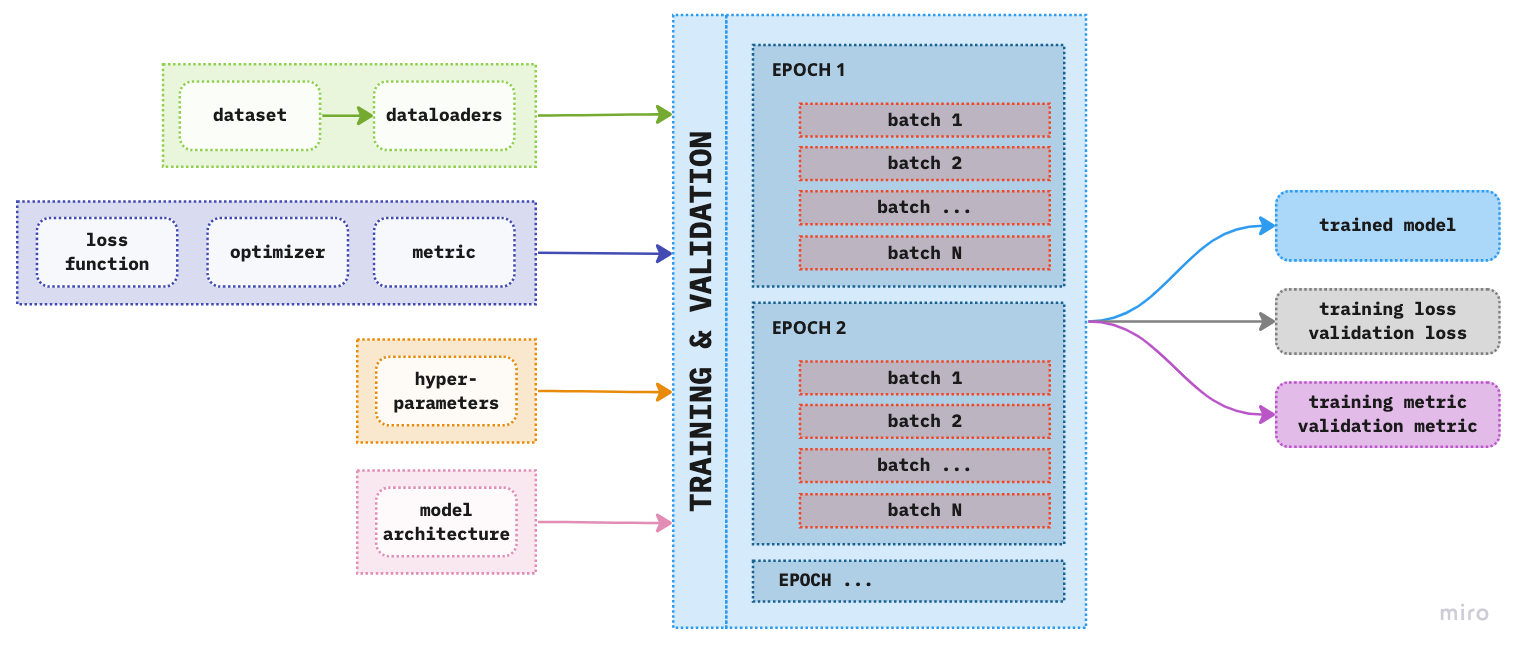
<cite>Figure 1. Extended overview of the components of deep learning modeling pipeline</cite><br><br>

Let's see briefly what each component is and why is needed.

## The Loss Function

Loss function provides the connection between our model predictions and the ground truth (the target labels) in form of a measure, which tells us how far our model predictions are from the target labels. It serves as a sort of a check *engine* whether our optimization process of the weights is going according to plan, i.e. our model is making better (more correct) predictions as we iterate the learning process.

The loss function needs to have certain properties to be useful in model training:
1. **differentiable** - if the loss function is not differentiable there are no gradients which would update the weights, without updating the weights there can be no change in the model predictions
2. **sensitive** - responds to small changes in weights which in turn means that it will change the prediction value. If there is no change in the prediction value the training iteration is useless.
3. It can be the same as model metric only if it satisfies the first 2 properties.

In this project the problem is of multi-class classification, and we should choose the loss function which will satisfy the above properties and provide us with the probabilities for each underlying class of labels. In most cases, cross entropy loss function is used. 

**Cross-entropy loss function** is made of two components:
1. the softmax activation function, and 
   - provides prediction probabilities for each class which sum to 1
2. the negative log likelihood
   - since we are transforming the values from `(0,1)` by means of taking the log the output range is then `(log(0), log(1)) = (-inf, 0)` and we need to multiply with `(-1)` to get the positive loss values.

The cross-entropy loss is defined in PyTorch as follows:

```python
loss_fun = nn.CrossEntropyLoss()
```

## Optimizer

The loss function gave us the information how far our model's outputs are from the labels. The next step is to try to minimize this loss, by adjusting the model parameters, for which we need two things: the direction to the potential minimum loss and the path to get there. The direction is given by the gradient of the loss function with respect to the parameters, while the path is given by the optimizer. The speed at which we would like to trod along this path is provided by the hyperparameter called **learning rate** (more on this in the next notebooks).

Optimizer is 

In the figure below the process of optimizing model parameters is given:

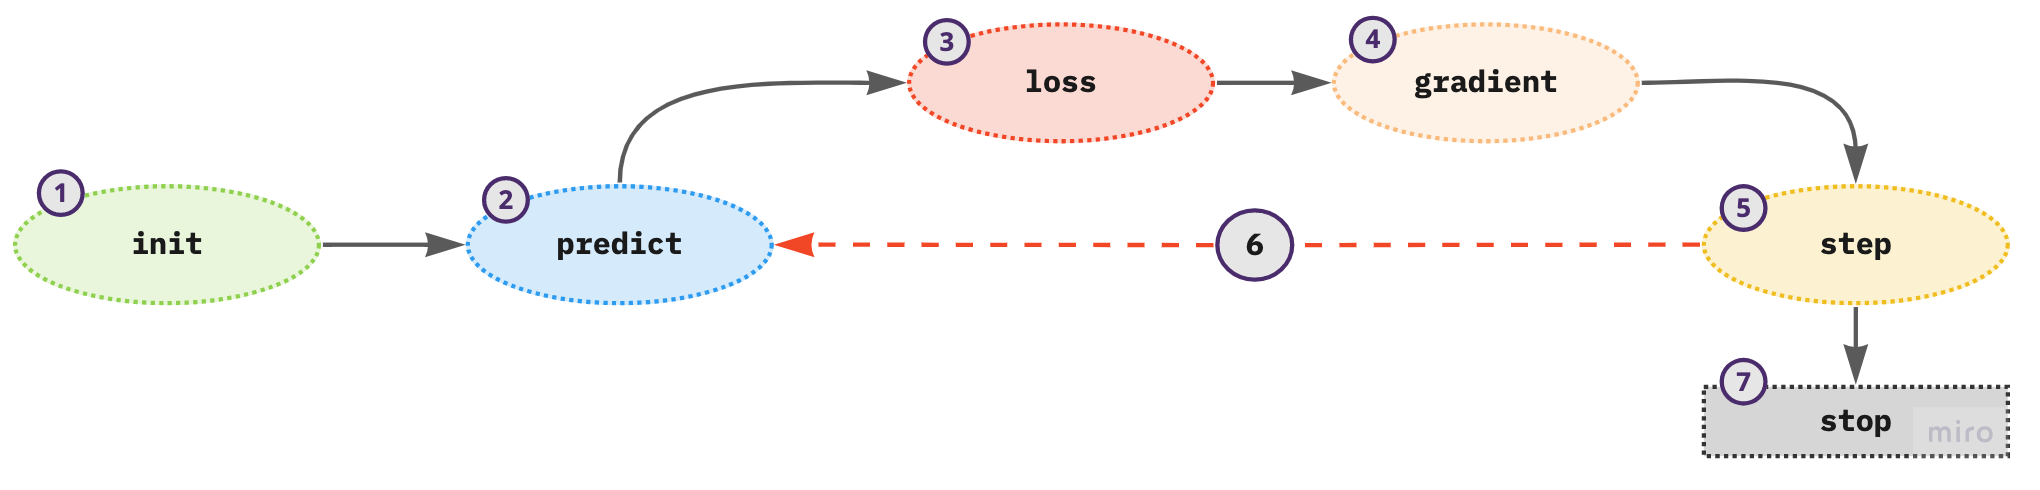
<cite>Figure 2. Process of updating the model parameters</cite>

1. initialize the weights - use random values
2. for each training sample in a mini-batch use the weights to compute the prediction
3. given the calculated predictions compute the model loss on the mini-batch
4. calculate the gradients of the loss with respect to weight parameters - tells us the direction of the loss for one unit change in the parameters
5. update the weights according to step (4)
6. repeat the steps from (2) to (5)
7. iterate until the model loss is low enough and the model is not overfitting or there is a time constraint

There are many optimizers to choose from like gradient descent (GD), stochastic gradient descent (SGD), Adagrad, RMSprop, Adam, etc. where GD and SGD is the first one you will most likely encounter in stuidying deep learning. For the purposes of this notebook we will use SGD and not dwelve into the details of a particular optimizers, this we leave for future notebook explainers. In PyTorch we can define it as follows:

```python
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
```

## Metric

The main goal of a model is to generalize well on unseen data. To achieve this goal we want to compute our model metrics on the validation set in order to see, while training, how our model behaves on data which is not used for training. Beware not to confuse that updating weights during training, via the loss function and gradients, is done using the training set. So in essence, we use training set to update the weights, but the metrics on the validation set tells us when to stop training in order to avoid overfitting.

Note that the loss function is used in training to optimize the weights of the model while the metric is used to assess the model performance. Model metric is given in terms of explainability of the model performance given the project goals. 

<div style="border: 0px solid #ccc; background-color: #A7CCD9; padding: 10px; margin: 14px 0; border-radius: 7px; font-size: 14px">
The metric needs to be "human understandable" while the loss function needs to be suitable mathematically for the optimization process (SGD).</div>

There can be instances that the loss function and metric are equally defined.

In this project, we want to see how many images are classified correctly so we can use a simple **accuracy** metric to acomplish this objective. There is no direct function in PyTorch for accuracy, so we define it directly within the training process with the following steps:
1. convert from probabilities to class labels
2. compare model class output to labels and sum the correct predictions
3. divide the sum of correct predictions with the total number of samples

## Hyperparameters

Hyperparameters are parameters that are defined before we start training and do not change during training, i.e. they are the parameters that are not updated. They should not be confused with weights and biases, which are actual model parameters and are updated, i.e. optimized during training.

Examples of hyperparameters include:
- batch size
- number of epochs
- learning rate
- regularization
- weight initialization

For this project, we will define the first three hyperparameters. The batch size we have already considered when defining the dataloaders, while the number of epochs and the learning rate is defined prior to training.

Note that as you change any of the hyperparameters the results of your deep learning model will change. *Finding* the best hyperparameters for your project is one of the key components of deep learning.

Since this is a first introductory notebook we will use only one value for the batch size, number of epochs, and learning rate. In later notebooks, we will explore the effects of the hyperparamters on the model results.

## Model Architecture

Model architecture provides the functional form of the model. It specifies how the input samples are passed through the collection of mathematical functions to obtain the final prediction value. Model architecture is comprised of layers, namely the input layer, hidden layers and the output layer. It is the stucture of the hidden layers that leads to deep networks, i.e. the more hidden layers the deeper the network. Model architecture, as you could imagine, has a direct impact on the performance of our model. With bigger (deeper) architecture we can expect better model performance, however with some cavetas. We can explore these in the future notebooks. For now we will consider a simple linear neural network to illustrate the process of defining the model architecture. As mentioned earlier, the goal of this notebook is not to train the best possible model, but to explain the modeling pipeline, which can then be tuned to develop a much better performing model.

A simple neural network with linear layers will provide a fast baseline to check that our modeling pipeline works. So first, we define the class for model architecture by inheriting from the PyTorch `nn.Module`, which is the base class for all neural network models. 

Within our model class we need to define the required `__init__` and `forward` methods. In order to invoke the`nn.Module` we need to add `super().__init__()` within the `__init__()` method. This ensures that `SimpleLNN` inherits all the basic functionality of `nn.Module` and it first executes the code in the parent's class i.e. in `nn.Module`.  The `forward` method defines how the data will pass through the defined network. 

Let's define the class `SimpleLNN`:

In [21]:
class SimpleLNN(nn.Module):
    """
    A simple linear neural network with 2 linear layers
    and an output layer with softmax activation function.
    
    in_shape (tuple): (height, width)
    n_out (int): number of outputs of the model
    """
    
    def __init__(self, in_shape:tuple, n_out:int):
        super().__init__()
        torch.manual_seed(1)
        np.random.seed(1)
        self.in_shape = in_shape
        H, W = self.in_shape
        self.n_out = n_out
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(H*W, self.n_out)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        
        return x

Given our simple neural network let's see how many parameters we have to train per each layer. We define a simple function ourselves as follows:

In [22]:
def cnt_params(model, show_per_layer:bool=True):
    """
    Get the number of model parameters for the instantiated model class.
    If show_per_layer then print info for each layer.
    """

    if show_per_layer:
        print('-'*75)
        print(f'PARAMETER INFORMATION PER LAYER')
        print('•'*75)
        for name, param in model.named_parameters():
            if param.ndim < 2: 
                in_fts = param.ndim
            else:
                in_fts = param.shape[1]
            out_fts = param.shape[0]
            print(f"Layer: {name}  | In Params: {in_fts}  | Out Params: {out_fts}  |  Total Params: {in_fts*out_fts}")
    
    total_cnt_params = sum([x.reshape(-1).shape[0] for x in model.parameters()])
    print('-'*75)
    print(f'Total number of parameter: {total_cnt_params}')
    print('-'*75)

    return total_cnt_params

In [23]:
model = SimpleLNN((28,28), 10)
_ = cnt_params(model)

---------------------------------------------------------------------------
PARAMETER INFORMATION PER LAYER
•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
Layer: linear.weight  | In Params: 784  | Out Params: 10  |  Total Params: 7840
Layer: linear.bias  | In Params: 1  | Out Params: 10  |  Total Params: 10
---------------------------------------------------------------------------
Total number of parameter: 7850
---------------------------------------------------------------------------


# Training & Validation

Now that we have all the components for the modeling pipeline we can go step further and define the training and validation pipeline. To illustrate the process please refer to the image below:

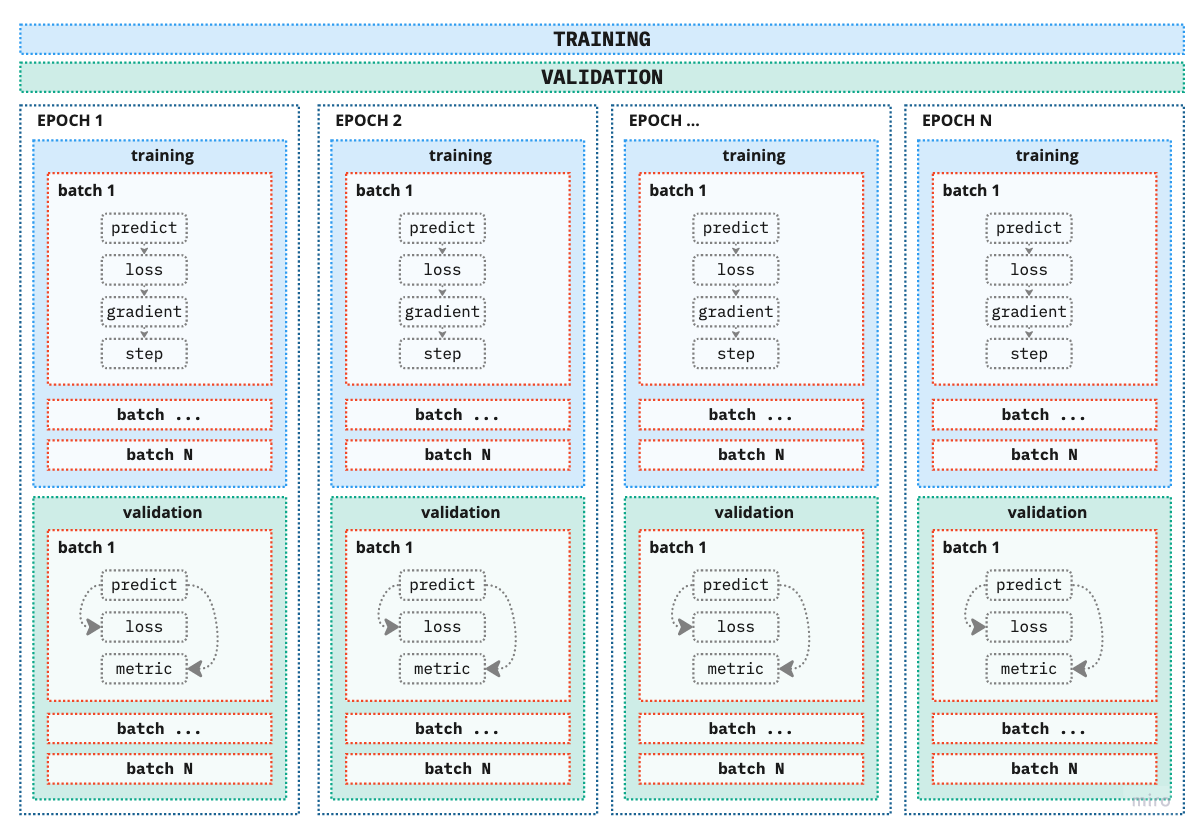
<cite>Figure 4. Training and validation pipeline</cite><br><br>

As you can notice we have expanded the training and validation box from previous figures to include blocks called **batches** and **epochs**. 

**Batch** - We have encountered batches when we createed dataloaders. As mentioned previously, number of batches can be considered as a hyperparameter, which depends on the underlying project of course. There are two extremes: 
- **1 sample**
  - Using only one sample would be super fast, however, we would also put all our eggs in one basket by "optimizing" (if this word can even be used here) our model based on only that one sample (surely all samples are not exactly the same). 
- **all samples**
  - On the other hand using all samples will provide us with the most information on how to update the weights however at the negative side of computer and time efficiency. So we need a *[[goldilocks mini-batch]]* zone. Finding this *goldilocks zone* is why this is also considered a hyperparameter, we adjust it according to the need of our model and project.

In later notebooks where we explain how to define a custom dataset and demonstrate different aspects of batch value on the model results.

**Epoch** is one full iteration of the model, i.e. the model has processed all the samples once. The more epochs we add to the training process the more times the model will update its parmeters and (hopefully) learn better but not memorize results.

One additional information we would need for training is on which **device** the model will train, CPU or GPU. Hopefully, we can utilize GPU for faster learning.

OK, so let's define a class `TrainModel`, which will take the inputs, process them in batches and epochs according to our model pipeline setup to return the outputs, namely trained model and training and validation loss and accuracy. Note that for the metric we will use *accuracy* since we are considering a classification problem. You can make this even more general by defining a metric as an input to the `TrainModel` class.

In [24]:
class TrainModel:
    """Training and validation of a simple neural network
    
    model: class which defines the model architecture
    dataloader_train: training data iterator in form of PyTorch dataloader class
    dataloader_valid: validation data iterator in form of PyTorch dataloader class
    no_epochs (int): number of epochs
    loss_fun: loss function
    optimizer: optimizer to be used in backpropagation
    lr_rate: learning rate for updating the parameters
    model_path_name (str): full path and name of the model
    verbose (bool): Print statmenents
    
    Example:
    # Initialize the class with arguments
    tm = TrainModel(model, no_epochs=10, 
                    loss_fun=nn.CrossEntropyLoss(), 
                    optimizer = torch.optim.SGD(model.parameters(), 
                    lr=lr_rate), lr_rate=0.1)
    # Train the model
    model_results = tm.train(dataloader_train, dataloader_valid)
    """
    
    
    def __init__(self, model, dataloader_train, dataloader_valid, 
                 no_epochs, loss_fun, optimizer, lr_rate, 
                 model_path_name:str, verbose:bool=None):
        self.model = model
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.no_epochs = no_epochs
        self.loss_fun = loss_fun
        self.optimizer = optimizer
        self.lr_rate = lr_rate
        self.model_path_name = model_path_name
        self.verbose = verbose
        
    def check_device(self):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if self.verbose:
            print(f'Using {device} device!')
        return device
    
    def train_epoch(self):
        """Training step for one epoch
        
        dataloader_train: training dataloader
        """
        
        # Get the device for training
        device = self.check_device() 
        
        # Define where to save training results
        loss_train = 0
        accuracy_train = 0
        no_correct = 0
        no_samples = 0

        # Initialize training mode
        model.train()

        # Loop through the batches in the dataloader
        for batch, (X,y) in enumerate(self.dataloader_train):

            # --- FORWARD PASS ---
            # Input data sent to device
            X, y = X.to(device), y.to(device)
            no_samples += X.size(0)
            
            # Model output - probability
            outputs = self.model(X)

            # Model prediction - class
            _,preds = torch.max(outputs.data,1)

            # Model loss & accuracy
            loss = self.loss_fun(outputs, y)
            # Sum of correct predictions
            correct_preds = (preds == y).sum().item()
            no_correct += correct_preds

            # --- BACKPROPAGATION ---
            # Clear the gradients
            self.optimizer.zero_grad()

            # Compute the gradients
            loss.backward()

            # Update the parameters
            self.optimizer.step()

            # --- SAVE & PRINT RESULTS ---
            # Save results of every batch
            loss_train += loss.item()*y.size(0)
            accuracy_train += correct_preds
            
        # Average the results
        loss_train /= no_samples
        accuracy_train /= no_samples

        print(colored(f'TrLoss: {loss_train}   TrAccuracy:[{no_correct}/{no_samples}] {accuracy_train}', 'blue'))

        return self.model, loss_train, accuracy_train
    
    
    def validate_epoch(self):
        """Validate the trained model for the epoch
        
        dataloader_valid: validation dataloader
        """
        
        # Get the device for training
        device = self.check_device()
        
        # Define where to save training results
        loss_valid = 0
        accuracy_valid = 0
        no_samples = 0
        no_correct = 0
        
        # Set the evaluation mode
        model.eval()

        with torch.no_grad():
            for batch, (Xv,yv) in enumerate(self.dataloader_valid):                
                
                # Input data sent to device
                Xv, yv = Xv.to(device), yv.to(device)
                no_samples += Xv.size(0)
                
                # Model output - probability
                outputs = self.model(Xv)

                # Model prediction - class
                _,preds = torch.max(outputs.data,1)
                
                # Model loss & accuracy
                loss = self.loss_fun(outputs, yv)
                correct_preds = (preds == yv).sum().item()
                no_correct += correct_preds

                # --- SAVE & PRINT RESULTS ---
                # Save results of every batch
                loss_valid += loss.item()*y.size(0)
                accuracy_valid += correct_preds

            # Average the results
            loss_valid /= no_samples
            accuracy_valid /= no_samples

        print(colored(f'VlLoss: {loss_valid}   VlAccuracy:[{no_correct}/{no_samples}] {accuracy_valid}','red'))
        
        return loss_valid, accuracy_valid
    
    
    def train(self):
        """Training the model for N epochs"""

        # Initialize for results
        loss_train_epoch = [0]*self.no_epochs
        accuracy_train_epoch = [0]*self.no_epochs
        loss_valid_epoch = [0]*self.no_epochs
        accuracy_valid_epoch = [0]*self.no_epochs

        for epoch in range(self.no_epochs):
            print(f'EPOCH: {epoch+1}')
            print('.'*75)
            
            model, loss_train, accuracy_train = self.train_epoch()
            loss_valid, accuracy_valid = self.validate_epoch()
            
            # Save results
            loss_train_epoch[epoch] = loss_train
            accuracy_train_epoch[epoch] = accuracy_train
            loss_valid_epoch[epoch] = loss_valid
            accuracy_valid_epoch[epoch] = accuracy_valid

            print('-'*75)
        
        # Save model results
        if self.model_path_name:
            torch.save(model, self.model_path_name)
            print(colored(f'Model saved in {self.model_path_name}','blue'))
        
        return loss_train_epoch, loss_valid_epoch, accuracy_train_epoch, accuracy_valid_epoch

Let's quickly explain how we have defined class `TrainModel`. The class `TrainModel` is composed of three methods: `train_epoch`, `validate_epoch` and `train`, where `train_epoch` and `validate_epoch` provide the training and validation for one epoch, while the `train` method encompases both to provide the complete modeling pipeline for a specified number of epochs.

Using `__init__()` we define all the arguments for the class.

```python
def __init__(self, model, dataloader_train, dataloader_valid, 
                 no_epochs, loss_fun, optimizer, lr_rate, 
                 model_path_name:str=None, verbose:bool=None):
        self.model = model
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.no_epochs = no_epochs
        self.loss_fun = loss_fun
        self.optimizer = optimizer
        self.lr_rate = lr_rate
        self.model_path_name = model_path_name
        self.verbose = verbose
```

In addition to the above mentioned methods, we also define the `check_device` method to define on which processor the model should be trained.

```python
def check_device(self):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if self.verbose:
            print(f'Using {device} device!')
        return device
```

***

**`train_epoch`** 

performs one epoch of training given the training dataloader and returns training loss and metric, which we defined to be accuracy for this project. Once we have defined the device to use for training we need to define all the objects where we will save the training results. We definitely need to see the training loss and accuracy to be able to compare with the validation results, but we also would like to print the number of correct predictions for each epoch with `no_correct`. In order to average the results from all the batches we need the number of samples for the complete epoch. Recall that since we have user sampler to create training and validation using simply `len(dataloader_train)` will give the number of samples from the original dataset. So, to get the number of samples per epoch of training we will simply add the number of samples per each batch to the object `no_samples`. Note that these are all defined to start at zero since we are adding a numeric value to each as we iterate through the batches.

```python
loss_train = 0
accuracy_train = 0
no_correct = 0
no_samples = 0
```

Next, we set the model to training mode with 
```python
model.eval()
```
which initializes the training process and activates some of the layers in our model and more specifically enables gradient computation.

Now we are ready to loop through the dataloader, i.e. through all the batches and compute the forward and backward pass of our neural network. The **forward pass** consists of the following:

```python
# Input data sent to device
X, y = X.to(device), y.to(device)
no_samples += X.size(0)

# Model output - probability
outputs = self.model(X)

# Model prediction - class
_,preds = torch.max(outputs.data,1)

# Model loss & accuracy
loss = self.loss_fun(outputs, y)
# Sum of correct predictions
correct_preds = (preds == y).sum().item()
no_correct += correct_preds
```
As we iterate through the dataloader we extract the tuple of inputs, namely images (`X`) and labels (`y`) and send them to defined processor, either CPU or GPU. Also, we add the number of samples from this batch to the `no_samples` object. Using the model architecture defined in `model` we pass the input images through to obtain the prediction. In order to be able to compare model output to labels, we need to convert the predictions to class labels for which we use `torch.max(outputs.data,1)`. It will output the index of a maximum value given the 1 dimension. Since the labels are digits from 0 to 9, if we get the index we will still get a value from 0 to 9. Note that if this is not the case you need to additional use a mapping function which defines the labels accordingly. Next, we compute model loss given out loss function. Note that we are using cross-entropy loss, which contains softmax and the negative log likelihood, which is the reason why we have not included the softmax layer in our model architecture. Finally, we compute the metric, i.e. accuracy, by simply summing the correct predictions and adding the number to `no_correct` for later use.

Having the loss function, we can compute the **backpropagation**:
```python
# Clear the gradients
self.optimizer.zero_grad()

# Compute the gradients
loss.backward()

# Update the parameters
self.optimizer.step()

# --- SAVE & PRINT RESULTS ---
# Save results of every batch
loss_train += loss.item()*y.size(0)
accuracy_train += correct_preds
```
Since the gradients accumulate as we iterate through the dataloader, we need to ensure that we get the gradients for the current batch. This is accomplished via `self.optimizer.zero_grad()`. Now it is safe to compute the gradients and call the `optimizer.step()` to update the weights. Remember **gradients tell us how much the model loss will change for a unit change in the parameters**. Lastly, we add the results of the model loss and number of correct predictions for the current batch. Note that `loss.item()` represent loss for the batch with the mean reduction. So in order to obtain the total loss for the batch we need to multiply with the size of the batch (number of samples) or `y.size(0)`. You can change the behavior of this by changing the argument `reduction` in the `CrossEntropyLoss`([source](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)).

Finally, we divide the loss and metric by the number of samples to obtain the average values of each.

<div style="border: 0px solid #ccc; background-color: #A7CCD9; padding: 10px; margin: 14px 0; border-radius: 7px; font-size: 14px">
You might wonder why are we dividing now and before we multiplied to get the total loss. After we trained for one epoch we need an average loss over that epoch. Now, consider that not all batches have to be of the same size and hence not all losses over each batch are on the same scale as the rest of the batches. For this reason we first multiply each batch loss with its size to get the total and then it is easy to get the epoch loss by dividing with the number of samples. Note that if all the batches are of the same size (for example you might have used the argument `drop_last` when constructing the dataloader) then you can simply add the loss.item() and get the epoch average loss by dividing with the number of batches. 
</div>

```python
loss_train /= no_samples
accuracy_train /= no_samples

print(colored(f'TrLoss: {loss.item()}   TrAccuracy:[{no_correct}/{no_samples}] {accuracy_train}', 'blue'))

return self.model, loss_train, accuracy_train    
```   

***

**`valid_epoch`** 

Difference between the validation and training step is that in the validation step we are only computing the forward based on the trained model in the training step; hence no need for backpropagation since we are not updating any parameters. We simply want to deduce how well our model for a given epoch is doing on unseen (during training) data. Similarly, as in `train_epoch` we define the device to train on and the objects to store the needed results of validation.

```python
# Get the device for training
device = self.check_device()

# Define where to save training results
loss_valid = 0
accuracy_valid = 0
no_samples = 0
no_correct = 0
```

We set the model to evaluation mode with 
```python
model.eval()
```
which tells the model to use the model architecture with the parameters, rather than activating layers for the calculation. Additionally, computation of gradients is disabled. Additionaly, to ensure no gradients are computed, the for loop over dataloader is inserted withint the `torch.no_grad()` which basically sets `requires_grad` of all tensors t `False`.
```python
with torch.no_grad():
    for batch, (Xv,yv) in enumerate(self.dataloader_valid):                
```
the rest of the computation for each bach comprises of a forward pass which is the same as in training, but now we are using a different dataset and no updates to the parameters is done. We simply want the loss and metric for each batch.

***
**`train()`**

The method `train()` encompases the previous two functions to finally create a training and validation loop. We loop through the number of epochs defined and store results for each epoch to be used later.
***

# Train the Model

To train the model we need the following:
- instantiate the model class and send it to device
- define the hyperparameters
- instantiate the modeling pipeline with the neccessary arguments
- call the method `train()` to start training and validation

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate the model architecture
model = SimpleLNN(in_shape=(28,28), n_out=10)

# Define the hyperparameters
no_epochs = 10
loss_fun = nn.CrossEntropyLoss()
lr_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

# Instantiate the modeling pipeline and call the `train()` method
model_path_name = MODELS_DIR/'basic_model.pt'
tm = TrainModel(model, dl_train, dl_valid, 
                no_epochs, loss_fun, optimizer, lr_rate, 
                model_path_name)
model_hist = tm.train()

EPOCH: 1
...........................................................................
TrLoss: 0.5240882821310134   TrAccuracy:[36422/42000] 0.8671904761904762
VlLoss: 0.37757085969713   VlAccuracy:[16183/18000] 0.8990555555555556
---------------------------------------------------------------------------
EPOCH: 2
...........................................................................
TrLoss: 0.3557209725096112   TrAccuracy:[37847/42000] 0.9011190476190476
VlLoss: 0.33839384280310736   VlAccuracy:[16303/18000] 0.9057222222222222
---------------------------------------------------------------------------
EPOCH: 3
...........................................................................
TrLoss: 0.3276261113257635   TrAccuracy:[38128/42000] 0.9078095238095238
VlLoss: 0.32149664380815296   VlAccuracy:[16383/18000] 0.9101666666666667
---------------------------------------------------------------------------
EPOCH: 4
......................................................................

# Visualizing Model Results

It would be nice to visually see the results of our training and validation. Let's create a simple plot of loss and metric for our model:

In [26]:
# loss_train_epoch, loss_valid_epoch, accuracy_train_epoch, accuracy_valid_epoch
model_results_colors = ['#F9A302', '#00474C'] # training and validation resp.

def plot_training_results(model_hist:list, metric_name:str):
    """Plot the model results: loss and metric
    
    model_hist: results of a trained model as a list with the following elements: 
                training loss, validation loss, training metric, and validation metric
    metric_name (str): name of the metric to insert in the plot title
    """
    plt.style.use('ggplot')
    figsize = (12,4)
    fig, ax = plt.subplots(1,2, figsize=figsize)
    
    # Model Loss
    plt.subplot(1,2,1)
    plt.title('Model Loss', size=12)
    plt.plot(model_hist[0], lw=2, c=model_results_colors[0], label='Training loss')
    plt.plot(model_hist[1], lw=2, c=model_results_colors[1], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    
    # Model Metric
    plt.subplot(1,2,2)
    plt.title('Model Metric', size=12)
    plt.plot(model_hist[2], lw=2, c=model_results_colors[0],  label=f'Training {metric_name}')
    plt.plot(model_hist[3], lw=2, c=model_results_colors[1], label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric_name}')
    plt.legend()

    plt.show()

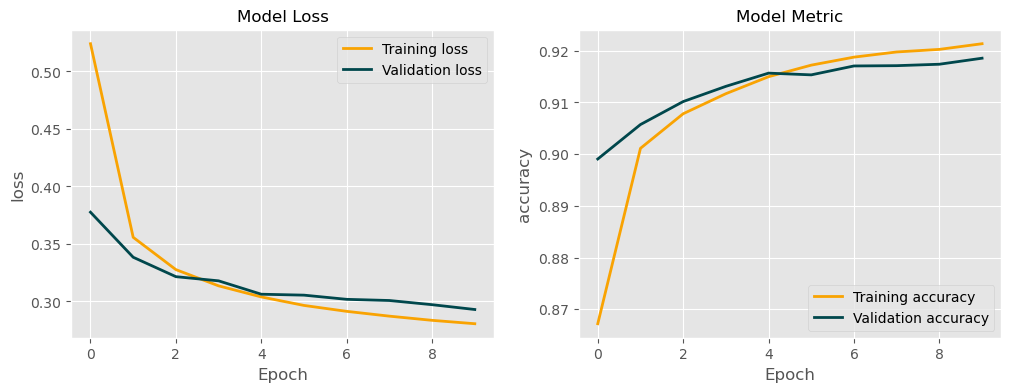

In [27]:
plot_training_results(model_hist, 'accuracy')

Furthermore, of great interest is to analyze where our model makes the most mistakes, i.e. for which classes. We can visualize the class predictions given model outputs and the labels using the confusion matrix. We can use the final saved model and compute predictions on the validation set. Let's define a new function for this:

In [28]:
def plot_confusion_matrix(conf_mat):
    """Plot confusion matrix from the pandas crosstab computation."""
    
    # Define custom cmap
    cmap_ofd = mcolors.LinearSegmentedColormap.from_list('diagonal', ['#4F4D8C','#2E4159'], N=256)
    cmap_d = mcolors.LinearSegmentedColormap.from_list('off diagonal', ['#F2F2F0','#5F5DA6'], N=256)

    plt.figure(figsize=(6,5))
    # Complete plot
    ax = sns.heatmap(conf_mat, annot=True, cmap=cmap_ofd, fmt='d', cbar=False)
    # Overlay the diagonal
    ax = sns.heatmap(conf_mat, annot=True, cmap=cmap_d, fmt='d', mask=np.eye(len(conf_mat)), cbar=False)

    # Place x-axis labels and ticks on top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label('Prediction Class')

    # Other styling options
    ax.set_yticklabels(ax.get_yticklabels(), va='center')
    
    plt.xlabel('Actual Class')
    plt.ylabel('Prediction Class')
    plt.tight_layout()
    plt.show()

In [29]:
def model_confusion_matrix(model_path_name, dataloader):
    """Compute model predictions on a given dataloader and plot the confusion matrix"""
    
    # Load the saved model
    model = torch.load(model_path_name)
    
    # Set the model into evaluation mode
    model.eval()

    # Object to save class prediction across batches
    preds_class = torch.empty((0,))
    labels = torch.empty((0,))
    
    with torch.no_grad():
        for batch, (Xv,yv) in enumerate(dataloader):                
            # Input data sent to device
            Xv, yv = Xv.to(device), yv.to(device)

            # Model output - probability
            outputs = model(Xv)

            # Model prediction - class
            _,preds = torch.max(outputs.data,1)
            preds_class = torch.cat((preds_class, preds))
            labels = torch.cat((labels, yv))
    
    # ----- CONFUSION MATRIX PLOT -----
    ct = pd.crosstab(preds_class.int(), labels.int(), rownames=['Prediction'], colnames=['Actual'])
    
    return preds_class, labels, ct

From the figure below we can now analyze where our model makes mistakes by comparing the predicted and actual class. It is no surprise that the largest numbers will be on the diagonal, i.e. the number of images that the model predicted correctly. All the values off the diagonal are misclassified images. Our objective is to reduce these values as much as we can.

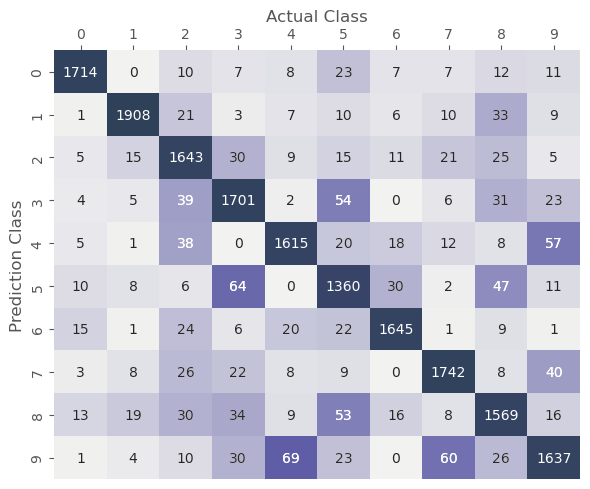

In [30]:
pc,lc,conf_mat = model_confusion_matrix(model_path_name, dl_valid)
plot_confusion_matrix(conf_mat)

In addition to above graphs, we can also see for which class the model makes the most mistakes regardless of what the prediction class is.

In [31]:
def misclass(pc, lc):
    plt.style.use('ggplot')
    df = pd.DataFrame({'preds': pc.numpy(),
                       'labels': lc.numpy()})
    df['misclass'] = (df.preds != df.labels).astype('int')
    df['labels'] = df['labels'].astype('int')
    df['miss_per_class'] = df.groupby('labels')['misclass'].transform('sum')
    df = df[['labels', 'miss_per_class']].drop_duplicates().reset_index(drop=True)#set_index('labels')
    
    sns.barplot(x='miss_per_class', y='labels', data=df, orient='h', 
                palette='GnBu')
    
    plt.xlabel('Number of wrong classifications per class', size=12)
    plt.ylabel('Actual Class', size=12)
    plt.show()

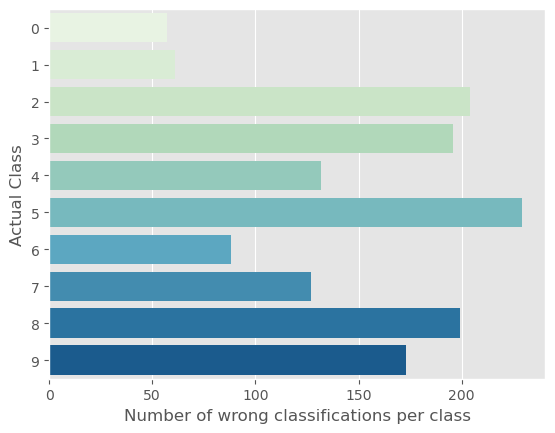

In [32]:
misclass(pc, lc)